# 🛠 Exercises

## 1. Take 3 of your photos of food and use the trained model to make predictions on them, share your predictions with the other students in Discord, and show off your Food Vision model 🍔👁.

In [1]:
# import libraries
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
# Get helper functions file
!wget https://raw.githubusercontent.com/yhs2773/TensorFlow-for-Deep-Learning/main/helper_functions.py

# Import series of helper functions for the notebook (we've created/used these in previous notebooks)
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_histories, walk_through_dir

--2023-12-07 07:44:17--  https://raw.githubusercontent.com/yhs2773/TensorFlow-for-Deep-Learning/main/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10872 (11K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.62K  --.-KB/s    in 0s      

2023-12-07 07:44:17 (88.3 MB/s) - ‘helper_functions.py’ saved [10872/10872]



In [3]:
# preparing and loading image function
def load_and_prep_image(filename, img_shape=224, scale=False):
    img = tf.io.read_file(filename)
    img = tf.io.decode_image(img)
    img = tf.image.resize(img, size = [img_shape, img_shape])

    if scale:
        return img / 255
    else:
        return img

In [4]:
# load pre-trained model from chapter 6
# Download pre-trained model from Google Storage (like a cooking show, I trained this model earlier, so the results may be different than above)
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
saved_model_path = "06_101_food_class_10_percent_saved_big_dog_model.zip"
unzip_data(saved_model_path)

# Note: loading a model will output a lot of 'WARNINGS', these can be ignored: https://www.tensorflow.org/tutorials/keras/save_and_load#save_checkpoints_during_training
# There's also a thread on GitHub trying to fix these warnings: https://github.com/tensorflow/tensorflow/issues/40166
# model = tf.keras.models.load_model("drive/My Drive/path/to/the/saved/model/") # path to drive model
model = tf.keras.models.load_model(saved_model_path.split(".")[0]) # don't include ".zip" in loaded model path

--2023-12-07 07:44:18--  https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.2.207, 142.250.101.207, 2607:f8b0:4023:c0b::cf, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.2.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46760742 (45M) [application/zip]
Saving to: ‘06_101_food_class_10_percent_saved_big_dog_model.zip’

06_101_food_class_1 100%[===================>]  44.59M   130MB/s    in 0.3s    

2023-12-07 07:44:19 (130 MB/s) - ‘06_101_food_class_10_percent_saved_big_dog_model.zip’ saved [46760742/46760742]



In [5]:
# Check model summary
model.summary()

Model: "functional_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_22 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 sequential_4 (Sequential)   (None, None, None, 3)     0         
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_average_pooling2d_9  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_8 (Dense)             (None, 101)               129381    
                                                                 
Total params: 4178952 (15.94 MB)
Trainable params: 41

In [6]:
# Download data to get class_names
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip

unzip_data("101_food_classes_10_percent.zip")

train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

--2023-12-07 07:44:49--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.2.207, 2607:f8b0:4023:c0b::cf, 2607:f8b0:4023:c0d::cf
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.2.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G   129MB/s    in 16s     

2023-12-07 07:45:05 (95.9 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [7]:
# Data into dataset
train_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                 label_mode='categorical',
                                                                 image_size=(224, 224))

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode='categorical',
                                                                image_size=(224, 224),
                                                                shuffle=False)

# Class names
class_names = train_data.class_names

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


In [8]:
# Get 3 custom photos
!wget -O "steak.jpeg" "https://images.unsplash.com/photo-1504674900247-0877df9cc836?q=80&w=2070&auto=format&fit=crop&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D"
!wget -O "pizza.jpeg" "https://images.unsplash.com/photo-1571066811602-716837d681de?q=80&w=1844&auto=format&fit=crop&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D"
!wget -O "pancake.jpeg" "https://images.unsplash.com/photo-1567620905732-2d1ec7ab7445?q=80&w=1980&auto=format&fit=crop&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D"

--2023-12-07 07:45:25--  https://images.unsplash.com/photo-1504674900247-0877df9cc836?q=80&w=2070&auto=format&fit=crop&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D
Resolving images.unsplash.com (images.unsplash.com)... 146.75.94.208, 2a04:4e42:87::720
Connecting to images.unsplash.com (images.unsplash.com)|146.75.94.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 787595 (769K) [image/jpeg]
Saving to: ‘steak.jpeg’

steak.jpeg          100%[===================>] 769.14K  --.-KB/s    in 0.03s   

2023-12-07 07:45:25 (22.4 MB/s) - ‘steak.jpeg’ saved [787595/787595]

--2023-12-07 07:45:25--  https://images.unsplash.com/photo-1571066811602-716837d681de?q=80&w=1844&auto=format&fit=crop&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D
Resolving images.unsplash.com (images.unsplash.com)... 146.75.94.208, 2a04:4e42:87::720
Connecting to images.unsplash.com (images.unsplash.com)|146.75.94.208|:443... connected.
HTTP

In [9]:
# Get image paths
filepaths = [img_f[2:] for img_f in glob.glob("./*.jpeg")]

1/1 [==============================] - 0s 30ms/step


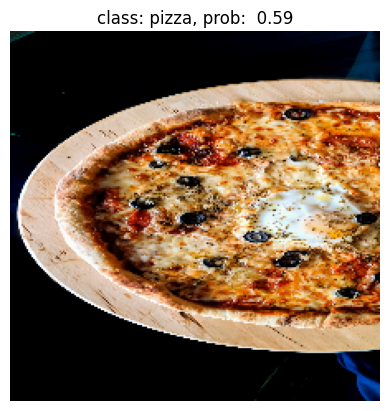

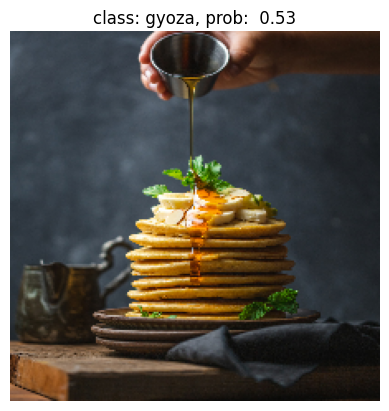

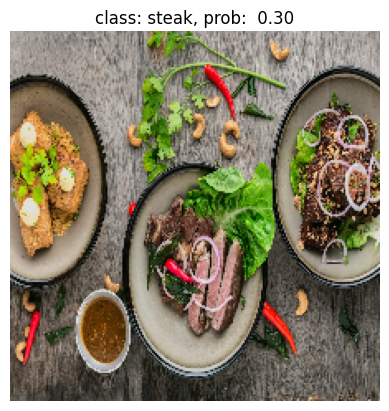

In [10]:
# Predict and plot custom images
for i in range(len(filepaths)):
    img = load_and_prep_image(filepaths[i], scale = False)
    pred_prob = model.predict(tf.expand_dims(img, axis = 0))
    pred_class = class_names[pred_prob.argmax()]

    plt.figure()
    plt.imshow(img / 255)
    plt.title(f"class: {pred_class}, prob: {pred_prob.max(): .2f}")
    plt.axis(False)

## 2. Train a feature-extraction transfer learning model for 10 epochs on the same data and compare its performance versus a model which used feature extraction for 5 epochs and fine-tuning for 5 epochs (like we've used in this notebook). Which method is better?

In [11]:
model.summary()

Model: "functional_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_22 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 sequential_4 (Sequential)   (None, None, None, 3)     0         
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_average_pooling2d_9  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_8 (Dense)             (None, 101)               129381    
                                                                 
Total params: 4178952 (15.94 MB)
Trainable params: 41

In [12]:
# Get pre-trained model
base_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top = False)

# Freeze pre-trained model
for layer in base_model.layers:
    layer.trainable = False

16705208/16705208 [==============================] - 0s 0us/step


In [13]:
# Configure model
inputs = model.get_layer("input_22").output
x = model.layers[1](inputs)
x = base_model(x, training = False)
x = model.layers[3](x)
outputs = model.layers[4](x)

model_2 = tf.keras.Model(inputs = inputs, outputs = outputs)

In [14]:
# Check model summary
model_2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_22 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 sequential_4 (Sequential)   (None, None, None, 3)     0         
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_average_pooling2d_9  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_8 (Dense)             (None, 101)               129381    
                                                                 
Total params: 4178952 (15.94 MB)
Trainable params: 129381 (50

In [15]:
# Compile a model
model_2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-4),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

# Train a model
history_2 = model_2.fit(train_data,
                        epochs=10,
                        validation_data=test_data,
                        validation_steps=int(len(test_data) * 0.15))

Epoch 1/10
237/237 [==============================] - 101s 393ms/step - loss: 1.4613 - accuracy: 0.6496 - val_loss: 1.8238 - val_accuracy: 0.5400
Epoch 2/10
237/237 [==============================] - 70s 292ms/step - loss: 1.4297 - accuracy: 0.6643 - val_loss: 1.8050 - val_accuracy: 0.5397
Epoch 3/10
237/237 [==============================] - 71s 297ms/step - loss: 1.4001 - accuracy: 0.6690 - val_loss: 1.7929 - val_accuracy: 0.5416
Epoch 4/10
237/237 [==============================] - 70s 293ms/step - loss: 1.3786 - accuracy: 0.6725 - val_loss: 1.7863 - val_accuracy: 0.5426
Epoch 5/10
237/237 [==============================] - 58s 243ms/step - loss: 1.3577 - accuracy: 0.6771 - val_loss: 1.7847 - val_accuracy: 0.5434
Epoch 6/10
237/237 [==============================] - 55s 230ms/step - loss: 1.3326 - accuracy: 0.6928 - val_loss: 1.7743 - val_accuracy: 0.5442
Epoch 7/10
237/237 [==============================] - 73s 308ms/step - loss: 1.3258 - accuracy: 0.6845 - val_loss: 1.7678 - val_a

In [16]:
model_2.evaluate(test_data)

790/790 [==============================] - 75s 95ms/step - loss: 1.5662 - accuracy: 0.5917


[1.5662226676940918, 0.5916831493377686]

In [17]:
model.evaluate(test_data)

790/790 [==============================] - 82s 100ms/step - loss: 2.0400 - accuracy: 0.5840


[2.039997100830078, 0.5840396285057068]

Feature extraction model seems to be better than the fine-tuned model.

## 3. Recreate our first model (the feature extraction model) with [`mixed_precision`](https://www.tensorflow.org/guide/mixed_precision) turned on.
- Does it make the model train faster?
    - It makes training faster
- Does it affect the accuracy or performance of our model?
    - Little
- What are the advantages of using `mixed_precision` training?
    - Train models faster
    - Yet, similar results (can be a little better or worse)

In [21]:
# Setting mixed_precision
policy = tf.keras.mixed_precision.Policy('mixed_float16')
tf.keras.mixed_precision.set_global_policy(policy)

In [22]:
# Recreate our first model
inputs = model_2.layers[0].output
x = model_2.layers[1](inputs)
x = model_2.layers[2](x)
x = model_2.layers[3](x)
# Final layer must have dtype as float32 to stablize figures
outputs = tf.keras.layers.Dense(len(class_names), activation = 'softmax', dtype = 'float32')(x)

model_3 = tf.keras.Model(inputs = inputs, outputs = outputs)

In [24]:
# Check model summary
model_3.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_22 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 sequential_4 (Sequential)   (None, None, None, 3)     0         
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_average_pooling2d_9  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
Total params: 4178952 (15.94 MB)
Trainable params: 129381 (

In [25]:
# Compile a model
model_3.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

# Train a model
history_3 = model_3.fit(train_data,
                        epochs=10,
                        validation_data=test_data,
                        validation_steps=int(len(test_data) * 0.15))

Epoch 1/10
237/237 [==============================] - 54s 188ms/step - loss: 1.0695 - accuracy: 0.7270 - val_loss: 1.5619 - val_accuracy: 0.5821
Epoch 2/10
237/237 [==============================] - 38s 157ms/step - loss: 1.0113 - accuracy: 0.7480 - val_loss: 1.5619 - val_accuracy: 0.5800
Epoch 3/10
237/237 [==============================] - 34s 140ms/step - loss: 0.9469 - accuracy: 0.7600 - val_loss: 1.5791 - val_accuracy: 0.5781
Epoch 4/10
237/237 [==============================] - 33s 136ms/step - loss: 0.9083 - accuracy: 0.7710 - val_loss: 1.6142 - val_accuracy: 0.5659
Epoch 5/10
237/237 [==============================] - 45s 188ms/step - loss: 0.8739 - accuracy: 0.7830 - val_loss: 1.5898 - val_accuracy: 0.5723
Epoch 6/10
237/237 [==============================] - 32s 134ms/step - loss: 0.8389 - accuracy: 0.7908 - val_loss: 1.5756 - val_accuracy: 0.5779
Epoch 7/10
237/237 [==============================] - 35s 144ms/step - loss: 0.8075 - accuracy: 0.7975 - val_loss: 1.6288 - val_ac

In [26]:
model_3.evaluate(test_data)

790/790 [==============================] - 71s 90ms/step - loss: 1.5189 - accuracy: 0.5989


[1.5189361572265625, 0.5988910794258118]

In [27]:
model_2.evaluate(test_data)

790/790 [==============================] - 61s 77ms/step - loss: 1.5662 - accuracy: 0.5917


[1.5662226676940918, 0.5916831493377686]

In [28]:
model.evaluate(test_data)

790/790 [==============================] - 62s 79ms/step - loss: 2.0400 - accuracy: 0.5840


[2.039997100830078, 0.5840396285057068]

# 📖 Extra-curriculum
- Spend 15 minutes reading up on the [EarlyStopping callback](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping). What does it do? How could we use it in our model training?
    - It monitors chosen metric and stops training if it doesn't improve any further
    - If we were to train for longer epochs, then we can utilize this callback to stop training earlier than the set number of epochs
- Spend an hour reading about [Streamlit](https://www.streamlit.io/). What does it do? How might you integrate some of the things we've done in this notebook into a Streamlit app?
    - It turns lines of code into an app
    - Use our model to accept images and classify what kind of food it is
    - We can also share the results of our experiments